In [16]:
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from gail.gail import GAILTrainer
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder, get_flow_params

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'
exp_name = 'latest_gail'
results_list = os.listdir('/headless/ray_results/' + exp_name)
AGENT = 'GAIL'
checkpoint = '150'
num_cpus = 60
num_trials = 50

benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.gail_flow_params

In [17]:
ray.init(num_cpus=num_cpus, include_webui=False, ignore_reinit_error=True)

2019-05-31 07:15:55,959	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-31_07-15-55_53770/logs.
2019-05-31 07:15:56,165	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:22722 to respond...
2019-05-31 07:15:56,370	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:50153 to respond...
2019-05-31 07:15:56,374	INFO services.py:804 -- Starting Redis shard with 10.0 GB max memory.
2019-05-31 07:15:56,551	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-31_07-15-55_53770/logs.
2019-05-31 07:15:56,555	INFO services.py:1427 -- Starting the Plasma object store with 18.23 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_address': '/tmp/ray/session_2019-05-31_07-15-55_53770/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-05-31_07-15-55_53770/sockets/raylet',
 'redis_address': '10.138.0.2:22722',
 'webui_url': None}

In [18]:
GAIL_PATH = 'GAILTrainer_MultiWaveAttenuationMergePOEnvGAIL-v0_3_discrim_lr=0.005_2019-05-31_00-57-4510ppymby'

In [19]:
PATH = ''
if AGENT == 'GAIL':
    PATH = exp_name + '/' + GAIL_PATH
    
config_path = '/headless/rl_project/ray_results/' + PATH + '/params.pkl'
checkpoint_path = '/headless/rl_project/ray_results/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

with open(config_path, mode='rb') as f:
    config = pickle.load(f)
config["expert_path"] = '/headless/rl_project/flow_codes/InverseRL/expert_sample'
flow_params = get_flow_params(config)
create_env, env_name = make_create_env(params=flow_params, version=0)
env = create_env()
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10

# Register as rllib env
register_env(env_name, create_env)

In [20]:
@ray.remote
def evaluate(create_env, AGENT, config=None, env_name=None, checkpoint_path=None):
    agent = None
    if AGENT == 'GAIL':
        agent = GAILTrainer(config=config, env=env_name)
        agent.restore(checkpoint_path)
        
    env = create_env()
    env.init_discriminator(128)
    env.set_state_dict(agent.discriminator.state_dict())
    
    left_length = env.k.scenario.edge_length('left')
    car_length = 5.0
    scale = 10
    
    # test until horizon
    state = env.reset()
    vel = []
    outflow = []
    for i in range(env.env_params.horizon):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            if env.k.vehicle.get_edge(id_) == 'left':
                vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(100)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    outflow = outflow[-500:]
    vel_map_list[vel_map_list==0.0] = np.nan

    return vel, outflow, vel_map_list

In [21]:
%%time
results = ray.get([evaluate.remote(create_env, AGENT, config, env_name, checkpoint_path) for _ in range(num_trials)])

2019-05-31 07:16:05,452	WARNING worker.py:334 -- WARNING: Falling back to serializing objects of type <class 'numpy.dtype'> by using pickle. This may be inefficient.


(pid=50736) 2019-05-31 07:16:28,784	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=50736) 2019-05-31 07:16:28,785	INFO json_reader.py:65 -- Found 1 input files.
(pid=50716) 2019-05-31 07:16:28,832	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=50716) 2019-05-31 07:16:28,833	INFO json_reader.py:65 -- Found 1 input files.
(pid=50725) 2019-05-31 07:16:28,828	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=50725) 2019-05-31 07:16:28,828	INFO json_reader.py:65 -- Found 1 input files.
(pid=50736) Loading configuration... done.
(pid=50736) Success.
(pid=50736) Loading configuration... done.
(pid=50716) Loading configuration... done.
(pid=50716) Success.
(pid=50729) 2019-05-31 07:16:29,032	WARNING json_reader.py:52 -- Treat

(pid=50732) 2019-05-31 07:16:31,443	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=50732) 2019-05-31 07:16:31.445690: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=50702) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50702)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50744) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50744)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50726) 20

(pid=50692) Loading configuration... done.
(pid=50692) Success.
(pid=50699) Loading configuration... done.
(pid=50738) 2019-05-31 07:16:32,801	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=50738) 2019-05-31 07:16:32,803	INFO json_reader.py:65 -- Found 1 input files.
(pid=50688) Success.
(pid=50686) 2019-05-31 07:16:32,796	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=50686) 2019-05-31 07:16:32,797	INFO json_reader.py:65 -- Found 1 input files.
(pid=50717) Loading configuration... done.
(pid=50696) Loading configuration... done.
(pid=50712) Loading configuration... done.
(pid=50712) Success.
(pid=50688) Loading configuration... done.
(pid=50692) Loading configuration... done.
(pid=50715) 2019-05-31 07:16:32,864	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/fl

(pid=50740) Loading configuration... done.
(pid=50721) Success.
(pid=50713) 2019-05-31 07:16:33,251	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=50713) 2019-05-31 07:16:33,252	INFO json_reader.py:65 -- Found 1 input files.
(pid=50704) Loading configuration... done.
(pid=50704) Success.
(pid=50734) 2019-05-31 07:16:33,268	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=50734) 2019-05-31 07:16:33,269	INFO json_reader.py:65 -- Found 1 input files.
(pid=50694) 2019-05-31 07:16:33,274	WARNING json_reader.py:52 -- Treating input directory as glob pattern: /headless/rl_project/flow_codes/InverseRL/expert_sample/*.json
(pid=50694) 2019-05-31 07:16:33,275	INFO json_reader.py:65 -- Found 1 input files.
(pid=50739) Loading configuration... done.
(pid=50739) Success.
(pid=50708) Loading configuration... done.
(pid=5

(pid=50730) Loading configuration... done.
(pid=50709) 2019-05-31 07:16:33,729	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=50709) 2019-05-31 07:16:33.731101: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=50741) 2019-05-31 07:16:33,779	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=50741) 2019-05-31 07:16:33.780819: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=50717) 2019-05-31 07:16:33,815	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=50717) 2019-05-31 07:16:33.816443: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions t

(pid=50731) 2019-05-31 07:16:34,205	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=50731) 2019-05-31 07:16:34.207376: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=50693) 2019-05-31 07:16:34,247	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=50693) 2019-05-31 07:16:34.249878: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=50727) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50727)   "Converting sparse IndexedSlices to a dense Tensor of unknown sha

(pid=50695) Loading configuration... done.
(pid=50691) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50691)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50711) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50711)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50686) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50686)   "Converting sparse IndexedSlices to a dense Tensor of unknown 

(pid=50722) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50722)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50689) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50689)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50737) 2019-05-31 07:16:35,408	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fec3e6b2b00>}
(pid=50737) 2019-05-31 07:16:35,408	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x

(pid=50726) Loading configuration... done.
(pid=50691) 2019-05-31 07:16:36,150	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fef81e53b38>}
(pid=50691) 2019-05-31 07:16:36,151	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fef81e53780>}
(pid=50691) 2019-05-31 07:16:36,151	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7fef81e53550>}
(pid=50733) 2019-05-31 07:16:36,196	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f1e9915cb38>}
(pid=50733) 2019-05-31 07:16:36,196	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f1e9915c7f0>}
(pid=50733) 2019-05-31 07:16:36,197	INFO policy_ev

(pid=50695) 2019-05-31 07:16:36,615	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=50734) 2019-05-31 07:16:36,679	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f2dac8f1b00>}
(pid=50734) 2019-05-31 07:16:36,679	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f2dac8f1748>}
(pid=50734) 2019-05-31 07:16:36,680	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7f2dac8f1518>}
(pid=50697) 2019-05-31 07:16:36,707	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f0e8f604b38>}
(pid=50697) 2019-05-31 07:16:36,707	INFO policy_evaluator.py:729 -- Built preprocessor map: {'def

(pid=50703) 2019-05-31 07:16:37,074	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f550f3b5b00>}
(pid=50703) 2019-05-31 07:16:37,074	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f550f3b5748>}
(pid=50703) 2019-05-31 07:16:37,074	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7f550f3b5518>}
(pid=50735) 2019-05-31 07:16:37,102	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fdffe0d4b38>}
(pid=50735) 2019-05-31 07:16:37,103	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fdffe0d47f0>}
(pid=50735) 2019-05-31 07:16:37,103	INFO policy_evaluator.py:343 -- Built filter map: {'defau

(pid=50730) Loading configuration... done.
(pid=50699) Loading configuration... done.
(pid=50741) Loading configuration... done.
(pid=50741) Success.
(pid=50717) Loading configuration... done.
(pid=50696) Loading configuration... done.
(pid=50741) Loading configuration... done.
(pid=50715) Loading configuration... done.
(pid=50715) Success.
(pid=50691) Loading configuration... done.
(pid=50715) Loading configuration... done.
(pid=50691) Success.
(pid=50691) Loading configuration... done.
(pid=50733) Loading configuration... done.
(pid=50733) Success.
(pid=50742) Loading configuration... done.
(pid=50742) Success.
(pid=50742) Loading configuration... done.
(pid=50733) Loading configuration... done.
(pid=50686) Loading configuration... done.
(pid=50686) Success.
(pid=50711) Loading configuration... done.
(pid=50738) Loading configuration... done.
(pid=50738) Success.
(pid=50711) Success.
(pid=50711) Loading configuration... done.
(pid=50686) Loading configuration... done.
(pid=50724) Loa

(pid=50738) 2019-05-31 07:16:40,583	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=50704) 2019-05-31 07:16:40,719	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=50693) 2019-05-31 07:16:40,828	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=50700) 2019-05-31 07:16:40,900	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=50746) 2019-05-31 07:16:40,990	INFO tf_run_builder.py:89 -- Executing TF run without tracing. To dump TF timeline traces to disk, set the TF_TIMELINE_DIR environment variable.
(pid=50728) 2019-05-31 07:16:40,943	INFO tf_run_builder.py:89 -- Executing TF run without traci

(pid=50736) Loading configuration... done.
(pid=50732) 2019-05-31 07:19:09,509	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 5 on CPU (please ignore any CUDA init errors)
(pid=50736) Success.
(pid=50736) Loading configuration... done.
(pid=50736) 2019-05-31 07:19:10,866	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 5 on CPU (please ignore any CUDA init errors)
(pid=50732) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50732)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50740) Closing connection to TraCI and stopping simulation.
(pid=50740) Note, this may print an error message when it closes.
(pid=50688) Closing connection to TraCI and stopping simulation.
(pid=50688) Note, this may print an error message when it closes.
(pid=50729) L

(pid=50730) Loading configuration... done.
(pid=50715) 2019-05-31 07:19:29,361	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 6 on CPU (please ignore any CUDA init errors)
(pid=50693) Loading configuration... done.
(pid=50710) Loading configuration... done.
(pid=50742) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50742)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50710) Success.
(pid=50710) Loading configuration... done.
(pid=50733) Loading configuration... done.
(pid=50733) Success.
(pid=50700) 2019-05-31 07:19:29,764	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 6 on CPU (please ignore any CUDA init errors)
(pid=50733) Loading configuration... done.
(pid=50706) Closing connection to TraCI and stopping simulation.
(pid=50706) Note,

(pid=50695) 2019-05-31 07:19:32,082	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 9 on CPU (please ignore any CUDA init errors)
(pid=50724) Loading configuration... done.
(pid=50742) Closing connection to TraCI and stopping simulation.
(pid=50742) Note, this may print an error message when it closes.
(pid=50742) Closing connection to TraCI and stopping simulation.
(pid=50742) Note, this may print an error message when it closes.
(pid=50742) Closing connection to TraCI and stopping simulation.
(pid=50742) Note, this may print an error message when it closes.
(pid=50703) 2019-05-31 07:19:32,265	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=50724) Success.
(pid=50708) Loading configuration... done.
(pid=50724) Loading configuration... done.
(pid=50708) Success.
(pid=50689) Loading configuration... done.
(pid=50689) Success.
(pid=50708) Loading configuration... done.
(pid=50713) /opt/conda/envs/flow-

(pid=50694) Loading configuration... done.
CPU times: user 7.07 s, sys: 991 ms, total: 8.06 s
Wall time: 3min 29s


In [22]:
vel_list = []
outflow_list = []
vel_map_lists = []
for vel, outflow, vel_map_list in results:
    vel_list.append(vel)
    outflow_list.append(outflow)
    vel_map_lists.append(vel_map_list)
vel_mean = np.mean(vel_list, axis=0)
outflow_mean = np.mean(outflow_list, axis=0)
vel_map_mean = np.nanmean(vel_map_lists, axis=0)      

(pid=50693) Closing connection to TraCI and stopping simulation.
(pid=50693) Note, this may print an error message when it closes.
(pid=50693) Closing connection to TraCI and stopping simulation.
(pid=50693) Note, this may print an error message when it closes.
(pid=50693) Closing connection to TraCI and stopping simulation.
(pid=50693) Note, this may print an error message when it closes.
(pid=50710) Closing connection to TraCI and stopping simulation.
(pid=50710) Note, this may print an error message when it closes.
(pid=50710) Closing connection to TraCI and stopping simulation.
(pid=50710) Note, this may print an error message when it closes.
(pid=50710) Closing connection to TraCI and stopping simulation.
(pid=50710) Note, this may print an error message when it closes.
(pid=50735) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a l

(pid=50708) Closing connection to TraCI and stopping simulation.
(pid=50708) Note, this may print an error message when it closes.
(pid=50689) Closing connection to TraCI and stopping simulation.
(pid=50689) Note, this may print an error message when it closes.
(pid=50689) Closing connection to TraCI and stopping simulation.
(pid=50689) Note, this may print an error message when it closes.
(pid=50689) Closing connection to TraCI and stopping simulation.
(pid=50689) Note, this may print an error message when it closes.
(pid=50720) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=50720)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=50701) Closing connection to TraCI and stopping simulation.
(pid=50701) Note, this may print an error message when it closes.
(pid=50701) Closing con

(pid=50716) Closing connection to TraCI and stopping simulation.
(pid=50716) Note, this may print an error message when it closes.
(pid=50716) Closing connection to TraCI and stopping simulation.
(pid=50716) Note, this may print an error message when it closes.
(pid=50716) Closing connection to TraCI and stopping simulation.
(pid=50716) Note, this may print an error message when it closes.
(pid=50728) Loading configuration... done.
(pid=50728) Success.
(pid=50728) Loading configuration... done.


/opt/conda/envs/flow-latest/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


(pid=50717) Closing connection to TraCI and stopping simulation.
(pid=50717) Note, this may print an error message when it closes.
(pid=50717) Closing connection to TraCI and stopping simulation.
(pid=50717) Note, this may print an error message when it closes.
(pid=50717) Closing connection to TraCI and stopping simulation.
(pid=50717) Note, this may print an error message when it closes.
(pid=50694) Closing connection to TraCI and stopping simulation.
(pid=50694) Note, this may print an error message when it closes.
(pid=50694) Closing connection to TraCI and stopping simulation.
(pid=50694) Note, this may print an error message when it closes.
(pid=50694) Closing connection to TraCI and stopping simulation.
(pid=50694) Note, this may print an error message when it closes.


In [32]:
try:
    np.save('gail_trained_'+str(num_trials)+'_vel.npy', vel_mean)
    np.save('gail_trained_'+str(num_trials)+'_outflow.npy', outflow_mean)
    np.save('gail_trained_'+str(num_trials)+'_vel_map.npy', vel_map_mean)
except:
    vel_mean = np.load('gail_trained_'+str(num_trials)+'_vel.npy')
    outflow_mean = np.load('gail_trained_'+str(num_trials)+'_outflow.npy')
    vel_map_mean = np.load('gail_trained_'+str(num_trials)+'_vel_map.npy')

human_vel_mean = np.load('human_'+str(num_trials)+'_vel.npy')
human_outflow_mean = np.load('human_'+str(num_trials)+'_outflow.npy')
human_vel_map_mean = np.load('human_'+str(num_trials)+'_vel_map.npy')

ppo_vel_mean = np.load('ppo_trained_'+str(num_trials)+'_vel.npy')
ppo_outflow_mean = np.load('ppo_trained_'+str(num_trials)+'_outflow.npy')
ppo_vel_map_mean = np.load('ppo_trained_'+str(num_trials)+'_vel_map.npy')

In [43]:
print('\n mean velocity [human: {:.1f}, ppo: {:.1f}, gail: {:.1f}]'.format(np.mean(human_vel_mean), 
                                                           np.mean(ppo_vel_mean),
                                                           np.mean(vel_mean)))
print(' \n mean outflow rate [human: {:.1f}, ppo: {:.1f}, gail: {:.1f}]'.format(np.mean(human_outflow_mean),
                                                                                np.mean(ppo_outflow_mean),
                                                                                np.mean(outflow_mean)))


 mean velocity [human: 10.1, ppo: 14.0, gail: 13.5]
 
 mean outflow rate [human: 1422.0, ppo: 1496.0, gail: 1551.0]


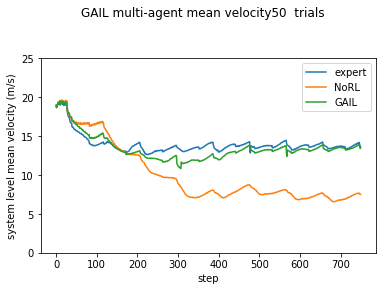

In [38]:
vel_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(ppo_vel_mean)
ax.plot(human_vel_mean)
ax.plot(vel_mean)
title = AGENT + ' multi-agent mean velocity'+str(num_trials)+'  trials'
ax.set_ylim((0, 25))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
ax.legend(['expert', 'NoRL', 'GAIL'])
vel_fig.suptitle(title)
plt.subplots_adjust(top=0.8)

Text(0.5, 0.98, 'GAIL multi-agent mean outflow 50 trials')

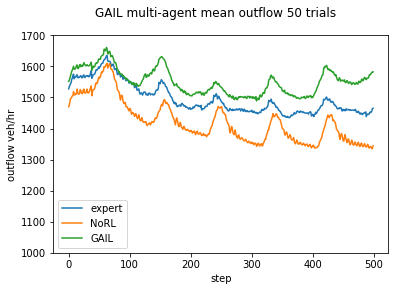

In [39]:
outflow_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(ppo_outflow_mean)
ax.plot(human_outflow_mean)
ax.plot(outflow_mean)
title = AGENT + ' multi-agent mean outflow '+ str(num_trials) +' trials'
ax.set_ylabel('outflow veh/hr')
ax.set_xlabel('step')
ax.set_ylim([1000, 1700])
ax.legend(['expert', 'NoRL', 'GAIL'])
outflow_fig.suptitle(title)
#plt.subplots_adjust(top=0.8)

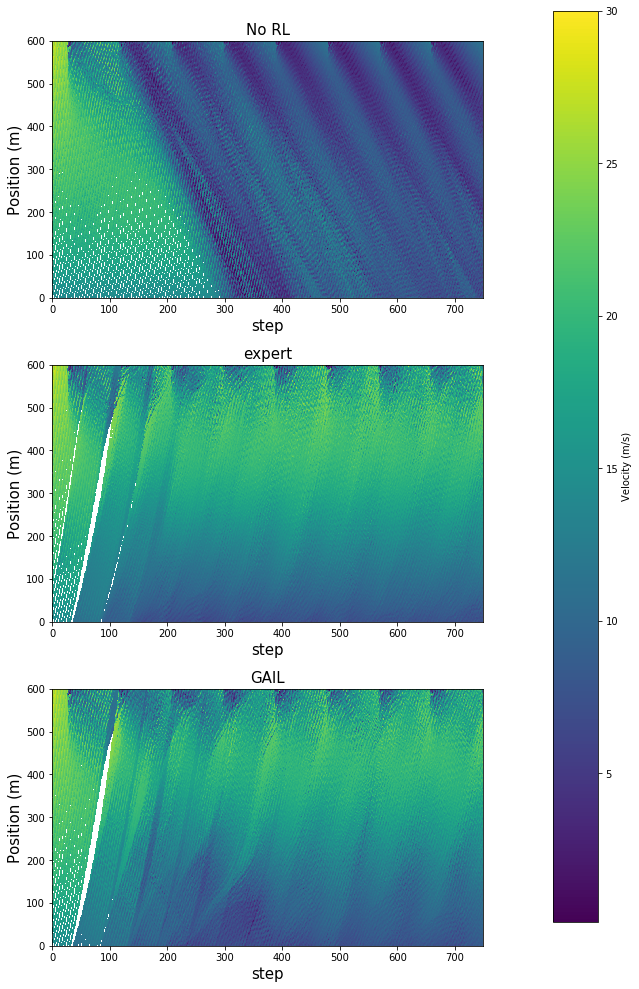

In [37]:
space_fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
space_fig.tight_layout(pad=5.0)

x = np.arange(int(750))
y = np.arange(0, int(600), step=0.1)
xx, yy = np.meshgrid(x, y)

# No RL
im = axes[0].pcolormesh(xx, yy, human_vel_map_mean.T)
axes[0].set_ylabel('Position (m)', fontsize=15.0)
axes[0].set_xlabel('step', fontsize=15.0)
axes[0].set_title('No RL', fontsize=15.0)

# RL
im = axes[1].pcolormesh(xx, yy, ppo_vel_map_mean.T)
axes[1].set_ylabel('Position (m)', fontsize=15.0)
axes[1].set_xlabel('step', fontsize=15.0)
axes[1].set_title('expert', fontsize=15.0)

# gail
im = axes[2].pcolormesh(xx, yy, vel_map_mean.T)
axes[2].set_ylabel('Position (m)', fontsize=15.0)
axes[2].set_xlabel('step', fontsize=15.0)
axes[2].set_title('GAIL', fontsize=15.0)

clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 600 meter merge road'
# space_fig.suptitle(title)   
plt.subplots_adjust(top=0.9, right=0.7)

In [28]:
vel_filename = 'compare_trained_human_vel_'+str(num_trials)+'.png'
outflow_filename = 'compare_trained_human_outflow_'+str(num_trials)+'.png'
congestion_filename = 'compare_trained_human_congestion_'+str(num_trials)+'.png'
dir_path = './result/MultiMerge/' + AGENT + '/' + exp_name + '/'+str(num_trials)+'/'
os.makedirs(dir_path, exist_ok=True)
vel_fig.savefig(dir_path + vel_filename)
outflow_fig.savefig(dir_path + outflow_filename)
space_fig.savefig(dir_path + congestion_filename)